In [1]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'imageRecog'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', 'cs639', 'linear_classifier.py', 'imgaeRecog.ipynb', 'logistics.ipynb']


In [3]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Central"
time.tzset()

from linear_classifier import hello_linear_classifier
hello_linear_classifier()

linear_classifier_path = os.path.join(GOOGLE_DRIVE_PATH, 'linear_classifier.py')
linear_classifier_edit_time = time.ctime(os.path.getmtime(linear_classifier_path))
print('linear_classifier.py last edited on %s' % linear_classifier_edit_time)

Hello from linear_classifier.py!
linear_classifier.py last edited on Thu Mar  9 17:52:24 2023


In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [5]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
data_dict = {}
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
data_dict['X_train'] = torch.tensor(x_train[:40000,:], dtype=float).view(40000, -1).cuda()
data_dict['y_train'] = torch.tensor(y_train[:40000], dtype=float).cuda()
data_dict['X_val'] = torch.tensor(x_train[40000:50000,:], dtype=float).view(10000, -1).cuda()
data_dict['y_val'] = torch.tensor(y_train[40000:50000], dtype=float).cuda()
data_dict['X_test'] = torch.tensor(x_test, dtype=float).view(10000, -1).cuda()
data_dict['y_test'] = torch.tensor(y_test, dtype=float).cuda()
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

11490434/11490434 [==============================] - 2s 0us/step
Train data shape:  torch.Size([40000, 784])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 784])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 784])
Test labels shape:  torch.Size([10000])


In [6]:
from linear_classifier import softmax_loss_naive, softmax_loss_vectorized, train_linear_classifier, reset_seed

reset_seed(0)
device = data_dict['X_train'].device
dtype = data_dict['X_train'].dtype
D = data_dict['X_train'].shape[1]
C = 10


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-7, reg=5.0e4,
                                       num_iters=1, verbose=True)


iteration 0 / 1: loss 392000002.302585


In [7]:
from linear_classifier import softmax_loss_vectorized, train_linear_classifier

reset_seed(0)

torch.cuda.synchronize()
tic = time.time()


W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-12, reg=1.2e4,
                                       num_iters=2000, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 2000: loss 2.302392
iteration 100 / 2000: loss 2.302589
iteration 200 / 2000: loss 2.302525
iteration 300 / 2000: loss 2.302168
iteration 400 / 2000: loss 2.302177
iteration 500 / 2000: loss 2.302558
iteration 600 / 2000: loss 2.302357
iteration 700 / 2000: loss 2.302617
iteration 800 / 2000: loss 2.302488
iteration 900 / 2000: loss 2.302315
iteration 1000 / 2000: loss 2.302547
iteration 1100 / 2000: loss 2.302626
iteration 1200 / 2000: loss 2.302602
iteration 1300 / 2000: loss 2.302449
iteration 1400 / 2000: loss 2.302293
iteration 1500 / 2000: loss 2.302346
iteration 1600 / 2000: loss 2.302329
iteration 1700 / 2000: loss 2.302314
iteration 1800 / 2000: loss 2.302782
iteration 1900 / 2000: loss 2.302454
That took 1.648907s


In [8]:
from linear_classifier import predict_linear_classifier

reset_seed(0)

# evaluate the performance on both the training and validation set

y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 12.60%
validation accuracy: 12.76%


In [27]:
import os
from linear_classifier import Softmax, softmax_get_search_params, test_one_param_set, reset_seed

learning_rates, regularization_strengths = softmax_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)


if num_models > 25:
  raise Exception("Please do not test/submit more than 25 items at once")
elif num_models < 5:
  raise Exception("Please present at least 5 parameter sets in your final ipynb")

i = 0
results = {}
best_val = -1.0   
best_softmax_model = None 
num_iters = 2000 

for lr in learning_rates:
  for reg in regularization_strengths:
    i += 1
    print('Training Softmax %d / %d with learning_rate=%e and reg=%e'
          % (i, num_models, lr, reg))
    
    reset_seed(0)
    cand_softmax_model, cand_train_acc, cand_val_acc = test_one_param_set(Softmax(), data_dict, lr, reg, num_iters)

    if cand_val_acc > best_val:
      best_val = cand_val_acc
      best_softmax_model = cand_softmax_model # save the classifier
    results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
  train_acc, val_acc = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Training Softmax 1 / 12 with learning_rate=1.150000e+01 and reg=1.500000e-05
tensor([[ 8.5016e+05,  5.1616e+06, -1.1921e+06,  ..., -6.7318e+05,
         -2.1276e+06,  8.1294e+05],
        [-2.2810e+06, -3.5157e+06, -1.4379e+06,  ..., -3.7176e+06,
         -1.9417e+06, -1.8995e+06],
        [ 5.9657e+05, -4.4745e+03,  4.1475e+05,  ..., -9.6407e+05,
         -1.9797e+06,  1.7566e+06],
        ...,
        [-7.3097e+05, -1.2689e+06, -1.0195e+06,  ...,  1.5254e+06,
         -1.3439e+06, -5.4813e+06],
        [-1.4601e+06, -8.1589e+05, -8.6937e+05,  ..., -9.6236e+04,
         -4.3079e+05, -1.1577e+06],
        [-1.6631e+05,  4.6632e+05,  8.4818e+05,  ...,  4.9789e+06,
          4.2119e+06, -1.7851e+06]], device='cuda:0', dtype=torch.float64)
tensor([[-1474243.7962,   168370.6826,  4303907.2677,  ...,
         -1290112.4007, -1117455.0194, -2943332.3988],
        [-1075492.6233, -3055708.1907, -3108200.9965,  ...,
           941933.0080, -1364706.8033,   -75884.6537],
        [ -301362.4760,

In [28]:
import struct
w = best_softmax_model.W.t()
# print(w)
print(w.reshape(-1).shape)
# print(w.reshape(-1))
#with open('weight.hex', 'w') as f:
  #sys.stdout = f
for i in range(len(w.reshape(-1))):
  print("@"+hex(i)[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', w.reshape(-1)[i].item()))[0])[2:].zfill(8), end="|")
print()

torch.Size([7840])
@0000 b41d6916|@0001 348f8943|@0002 34b0fc26|@0003 b5318680|@0004 34bfbd10|@0005 3494826c|@0006 b53882ee|@0007 35731f24|@0008 33ce1ca3|@0009 35044155|@000a 339ccc85|@000b 34080276|@000c 35062ba1|@000d 3501700a|@000e 35577bc3|@000f 33df46e2|@0010 b524a549|@0011 34b8db17|@0012 b3d17e5c|@0013 34870abc|@0014 33ca13b6|@0015 b4a15135|@0016 35867760|@0017 b58d90b7|@0018 331d25a0|@0019 b42a750c|@001a b426a458|@001b b4ffcebb|@001c 345f5454|@001d b40c3f7a|@001e b4875b65|@001f 34bdf575|@0020 b552175c|@0021 3569109e|@0022 b432f05d|@0023 b4419c94|@0024 b3a0958b|@0025 b29ffdbf|@0026 bf34342a|@0027 426fbca4|@0028 42ffe6c4|@0029 42588510|@002a bf895805|@002b 41b579b4|@002c 42993656|@002d 422447aa|@002e bd7cebfb|@002f b5237b3e|@0030 b4e69441|@0031 347c2d7b|@0032 b4936fcf|@0033 b53cb005|@0034 b52ffda3|@0035 b52a47d8|@0036 354a3df5|@0037 35ad43fa|@0038 b500984b|@0039 b5956c05|@003a b503bca1|@003b 4090abc2|@003c 3fc78bc7|@003d 34a851aa|@003e 343affca|@003f 41cd308d|@0040 bed3f163|@0041 

In [26]:
for i in range(len(w.reshape(-1))):
  print(w.reshape(-1)[i].item())
print()

Streaming output truncated to the last 5000 lines.
-564.2112836407279
-696.4743205913073
-381.60183347796107
-254.5043074909686
372.9425750163245
262.5727299062665
744.3749438452141
24.855973349775738
97.83785168398066
418.71967577485344
53.82319460692325
-358.0689459828798
-214.4229517017384
-15.054994174686964
5.104684859704639e-07
-3.8168078035221614e-07
0.6351946731799192
123.86772107513222
668.9239449275071
562.599193054725
582.1547122192859
280.87266378952296
-110.48912273788882
-226.41816076650406
-681.1332047850154
-703.0658366273158
-956.4423103999404
-924.5963350136716
-665.8064237741704
-699.2120647634457
418.7533121630089
391.18292981293405
266.95752728448815
356.3935869862447
298.4463362092904
47.230409763244204
505.3484156784972
590.7630785223919
-27.800917965317502
-454.87019464415624
-172.16083527484827
-8.699138441411428
4.132260280225722e-07
6.762955954266566e-07
3.4125834314449217e-07
-77.37487399005641
732.1210185682133
727.082073985975
1165.028893224623
329.7777832

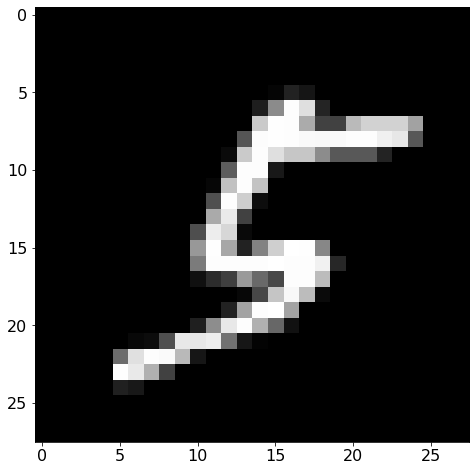

In [33]:
from matplotlib import pyplot as plt
import numpy as np

index = 9023
data_x_val = data_dict['X_val'].cpu()
plt.imshow(data_x_val[index].reshape(28, 28), cmap='gray')
plt.show()

In [34]:
print(data_x_val[index])

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   

In [35]:
for i in range(len(data_x_val[index])):
  print("@"+hex(i)[2:].zfill(4)+" "+hex(int(data_x_val[index][i]))[2:].zfill(2), end="|")
print()

@0000 00|@0001 00|@0002 00|@0003 00|@0004 00|@0005 00|@0006 00|@0007 00|@0008 00|@0009 00|@000a 00|@000b 00|@000c 00|@000d 00|@000e 00|@000f 00|@0010 00|@0011 00|@0012 00|@0013 00|@0014 00|@0015 00|@0016 00|@0017 00|@0018 00|@0019 00|@001a 00|@001b 00|@001c 00|@001d 00|@001e 00|@001f 00|@0020 00|@0021 00|@0022 00|@0023 00|@0024 00|@0025 00|@0026 00|@0027 00|@0028 00|@0029 00|@002a 00|@002b 00|@002c 00|@002d 00|@002e 00|@002f 00|@0030 00|@0031 00|@0032 00|@0033 00|@0034 00|@0035 00|@0036 00|@0037 00|@0038 00|@0039 00|@003a 00|@003b 00|@003c 00|@003d 00|@003e 00|@003f 00|@0040 00|@0041 00|@0042 00|@0043 00|@0044 00|@0045 00|@0046 00|@0047 00|@0048 00|@0049 00|@004a 00|@004b 00|@004c 00|@004d 00|@004e 00|@004f 00|@0050 00|@0051 00|@0052 00|@0053 00|@0054 00|@0055 00|@0056 00|@0057 00|@0058 00|@0059 00|@005a 00|@005b 00|@005c 00|@005d 00|@005e 00|@005f 00|@0060 00|@0061 00|@0062 00|@0063 00|@0064 00|@0065 00|@0066 00|@0067 00|@0068 00|@0069 00|@006a 00|@006b 00|@006c 00|@006d 00|@006e 00|@

In [37]:
data_y_val = data_dict['y_val'].cpu()
print(data_y_val[index].item())

5.0


In [42]:
print(w.shape)
print(data_x_val[index].reshape(784,1).shape)
print(type(w))
print(type(data_x_val))

torch.Size([10, 784])
torch.Size([784, 1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [44]:
score = torch.mm(w, data_dict['X_val'][index].reshape(784,1))
score

tensor([[  857564.5165],
        [-1132573.3732],
        [  630154.5283],
        [ 1534216.0034],
        [ -616171.4341],
        [ 2072182.4823],
        [ -617755.0037],
        [ -781613.4746],
        [-1287100.8388],
        [ -658903.4046]], device='cuda:0', dtype=torch.float64)

In [47]:
pred = torch.argmax(score).item()
pred

5